In [1]:
import hydra
from omegaconf import DictConfig

from shell.fleet.utils.fleet_utils import get_fleet, get_agent_cls
import os
import time
import datetime
import logging
from shell.utils.experiment_utils import setup_experiment

import os
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

In [2]:
save_root_dir = "tmp_play_results"
dataset = "cifar100"
algo = "modular"
num_train = 256
seed = 0
use_contrastive = True

job_name = f"{dataset}_{algo}_numtrain_{num_train}"
if use_contrastive:
    job_name += "_contrastive"
experiment = os.path.join(save_root_dir, job_name, dataset,algo, f"seed_{seed}")

In [3]:
config_path = os.path.join(experiment, "hydra_out", ".hydra", "config.yaml")
# read the config file
cfg = omegaconf.OmegaConf.load(config_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/vlongle/code/learning-hive/tmp_play_results/cifar100_modular_numtrain_256_contrastive/cifar100/modular/seed_0/hydra_out/.hydra/config.yaml'

In [ ]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, cfg.parallel)

graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg = setup_experiment(
    cfg)

FleetCls = get_fleet(cfg.sharing_strategy, cfg.parallel)

fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)


dataset = datasets[0].trainset[0]


agent = fleet.agents[0].agent
net = agent.net
import torch
task_id = 4
net.add_tmp_module(task_id)
net.load_state_dict(torch.load(
    "tmp_no_dropout_no_update_modules_checkpt_results/cifar100_modular_numtrain_256_contrastive/cifar100/modular/seed_0/agent_0/task_4/checkpoint.pt")['model_state_dict'])
# net.load_state_dict(torch.load(
#     "tmp_no_dropout_no_update_modules_checkpt_results/cifar100_modular_numtrain_256_contrastive/cifar100/modular/seed_0/agent_0/task_3/checkpoint.pt")['model_state_dict'])
print(net)
print(net.structure[0])
print(net.structure[1])
print(net.structure[2])
print(net.structure[3])
print(net.structure[4])

testloaders = {task: torch.utils.data.DataLoader(testset,
                                                    batch_size=128,
                                                    #  batch_size=256,
                                                    shuffle=False,
                                                    num_workers=0,
                                                    #  num_workers=4,
                                                    pin_memory=True,
                                                    ) for task, testset in enumerate(datasets[0].testset[:(task_id+1)])}
from shell.utils.experiment_utils import eval_net
print(eval_net(net, testloaders))

for t in range(task_id):
    trainloader = torch.utils.data.DataLoader(datasets[0].trainset[t],
                                                batch_size=128,
                                                #  batch_size=256,
                                                shuffle=True,
                                                num_workers=0,
                                                #  num_workers=4,
                                                pin_memory=True,
                                                )
    agent.update_multitask_cost(trainloader, t)
print(len(agent.replay_buffers[0]))

# take one update_modules step!
cur_trainloader = torch.utils.data.DataLoader(datasets[0].trainset[task_id],
                                                batch_size=64,
                                                shuffle=True,
                                                num_workers=0,
                                                pin_memory=True,
                                                )

valloader = torch.utils.data.DataLoader(datasets[0].valset[task_id],
                                        batch_size=128,
                                        shuffle=False,
                                        num_workers=0,
                                        pin_memory=True,
                                        )


{'train': {'component_update_freq': 200, 'num_epochs': 100, 'init_component_update_freq': 200, 'init_num_epochs': 100, 'save_freq': 1}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 5, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256_contrastive', 'num_agents': 1, 'root_save_dir': 'tmp_play_results', 'parallel': False, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}
i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 

In [ ]:
cur_trainloader.sampler

In [ ]:
for X, Y in cur_trainloader:
    Y = Y.to(agent.net.device)
    X = torch.cat([X[0], X[1]], dim=0)
    X = X.to(agent.net.device, non_blocking=True)
    agent.compute_loss(X, Y, task_id, log=True)

task 4 size 64 no components 5 cl: tensor(0.0650, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)
task 4 size 64 no components 5 cl: tensor(0.0645, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0078, device='cuda:0', grad_fn=<DivBackward0>)
task 4 size 64 no components 5 cl: tensor(0.0645, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0072, device='cuda:0', grad_fn=<DivBackward0>)
task 4 size 64 no components 5 cl: tensor(0.0651, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)
task 4 size 64 no components 5 cl: tensor(0.0652, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0080, device='cuda:0', grad_fn=<DivBackward0>)
task 4 size 64 no components 5 cl: tensor(0.0659, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)
task 4 size 64 no components 5 cl: tensor(0.0668, device='cuda:0', grad_fn=<DivBackward0>) ce:

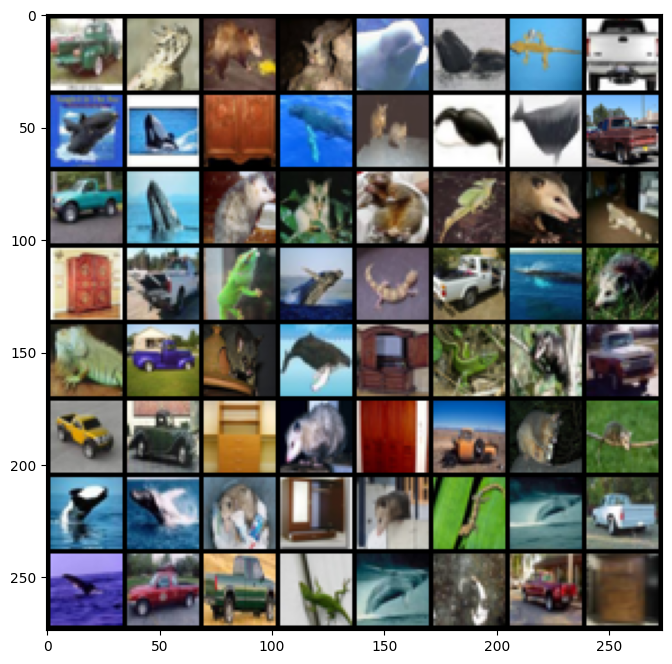

In [ ]:
# make_grid from X then plt.imshow
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

X_o = X[:64]
X_o = X_o.cpu()
images = make_grid(X_o)
plt.figure(figsize=(20, 8))
plt.imshow(np.transpose(images, (1, 2, 0)));

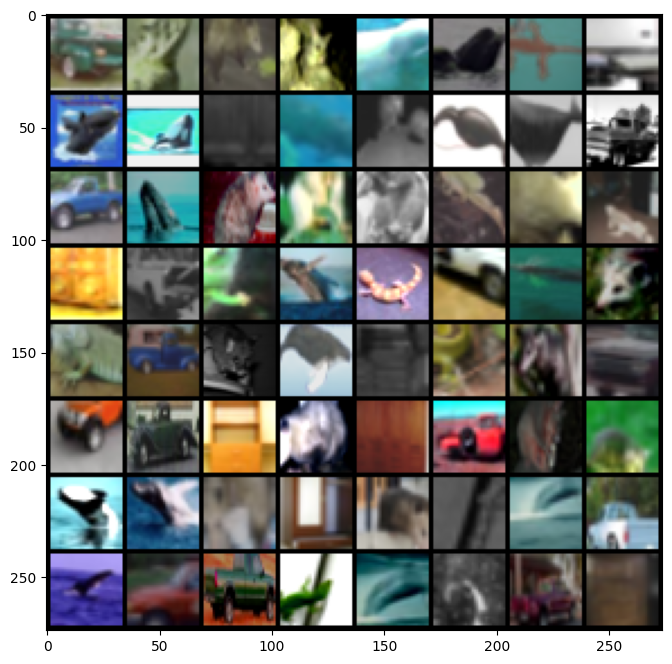

In [ ]:
X_a = X[64:]
X_a = X_a.cpu()
images = make_grid(X_a)
plt.figure(figsize=(20, 8))
plt.imshow(np.transpose(images, (1, 2, 0)));

In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset

    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(
        self,
        dataset,
        labels,
        indices: list = None,
        num_samples: int = None,
    ):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices
        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset) if labels is None else labels
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
import copy
import torch
import torch.nn as nn
import os
from torch.utils.data.dataset import ConcatDataset
import copy
from shell.utils.replay_buffers import ReplayBufferReservoir
from shell.learners.base_learning_classes import CompositionalDynamicLearner
from shell.datasets.datasets import get_custom_tensordataset

tmp_dataset = copy.deepcopy(cur_trainloader.dataset)
tmp_dataset.tensors = tmp_dataset.tensors + \
            (torch.full((len(tmp_dataset),), task_id, dtype=int),)

mega_dataset = ConcatDataset(
            [get_custom_tensordataset(loader.dataset.tensors, name=agent.dataset_name,
                                      use_contrastive=agent.use_contrastive) for loader in agent.memory_loaders.values()] + [tmp_dataset])

# mega_dataset = ConcatDataset(
#             [get_custom_tensordataset(loader.dataset.tensors, name=agent.dataset_name,
#                                       use_contrastive=agent.use_contrastive) for loader in agent.memory_loaders.values()])

batch_size = cur_trainloader.batch_size
# mega_loader = torch.utils.data.DataLoader(mega_dataset,
#                                                   batch_size=batch_size,
#                                                 #   shuffle=True,
#                                                   shuffle=False,
#                                                   num_workers=0,
#                                                   pin_memory=True
#                                                   )

In [ ]:
# weights = task_count / len(mega_dataset)
labels = torch.cat([loader.dataset.tensors[2] for loader in agent.memory_loaders.values()] + [tmp_dataset.tensors[2]])
# flatten labels
labels

tensor([0, 0, 0,  ..., 4, 4, 4])

In [ ]:
mega_loader = torch.utils.data.DataLoader(
    mega_dataset,
sampler=ImbalancedDatasetSampler(mega_dataset, labels),
batch_size=batch_size,
)

In [ ]:
agent.set_loss_reduction('sum')
# agent.set_loss_reduction('mean')
for X, Y, t in mega_loader:
    if isinstance(X, list):
        # contrastive two views
        X = torch.cat([X[0], X[1]], dim=0)

    X = X.to(agent.net.device, non_blocking=True)
    Y = Y.to(agent.net.device, non_blocking=True)

    all_t = torch.unique(t) 
    if agent.use_contrastive:
        Xhaf = X[:len(X)//2]
        Xother = X[len(X)//2:]

    for task_id_tmp in all_t:
        Yt = Y[t == task_id_tmp]
        if agent.use_contrastive:
            # Xt will be twice as long as Yt
            # use advanced indexing to get the first half
            Xt_haf = Xhaf[t == task_id_tmp]
            Xt_other = Xother[t == task_id_tmp]
            Xt = torch.cat([Xt_haf, Xt_other], dim=0)
        agent.compute_loss(Xt,
                            Yt, task_id_tmp,
                                       mode=None,
                                       log=True,
                                       )

task tensor(0) size 9 no components 5 cl: tensor(2.0189, device='cuda:0') ce: tensor(0.0010, device='cuda:0')
task tensor(1) size 15 no components 5 cl: tensor(2.9525, device='cuda:0') ce: tensor(0.0414, device='cuda:0')
task tensor(2) size 12 no components 5 cl: tensor(2.4370, device='cuda:0') ce: tensor(0.0174, device='cuda:0')
task tensor(3) size 18 no components 5 cl: tensor(2.7389, device='cuda:0') ce: tensor(0.0006, device='cuda:0')
task tensor(4) size 10 no components 5 cl: tensor(2.2321, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.3645, device='cuda:0', grad_fn=<DivBackward0>)
task tensor(0) size 16 no components 5 cl: tensor(2.5563, device='cuda:0') ce: tensor(0.0044, device='cuda:0')
task tensor(1) size 7 no components 5 cl: tensor(1.7968, device='cuda:0') ce: tensor(0.0066, device='cuda:0')
task tensor(2) size 14 no components 5 cl: tensor(2.6082, device='cuda:0') ce: tensor(0.0415, device='cuda:0')
task tensor(3) size 17 no components 5 cl: tensor(3.0146, device='

In [ ]:
agent.sup_loss.reduction

'sum'

In [ ]:
agent.set_loss_reduction('sum')
# agent.set_loss_reduction('mean')
for X, Y, t in mega_loader:
    if isinstance(X, list):
        # contrastive two views
        X = torch.cat([X[0], X[1]], dim=0)

    X = X.to(agent.net.device, non_blocking=True)
    Y = Y.to(agent.net.device, non_blocking=True)

    all_t = torch.unique(t) 
    if agent.use_contrastive:
        Xhaf = X[:len(X)//2]
        Xother = X[len(X)//2:]

    for task_id_tmp in all_t:
        Yt = Y[t == task_id_tmp]
        if agent.use_contrastive:
            # Xt will be twice as long as Yt
            # use advanced indexing to get the first half
            Xt_haf = Xhaf[t == task_id_tmp]
            Xt_other = Xother[t == task_id_tmp]
            Xt = torch.cat([Xt_haf, Xt_other], dim=0)
        agent.compute_loss(Xt,
                            Yt, task_id_tmp,
                                       mode=None,
                                       log=True,
                                       )

task tensor(0) size 2 no components 5 cl: tensor(0.4166, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)
task tensor(2) size 3 no components 5 cl: tensor(1.1085, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
task tensor(3) size 1 no components 5 cl: tensor(5.0068e-06, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0317, device='cuda:0', grad_fn=<DivBackward0>)
task tensor(4) size 58 no components 5 cl: tensor(4.0227, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.5063, device='cuda:0', grad_fn=<DivBackward0>)
task tensor(1) size 1 no components 5 cl: tensor(1.3039e-06, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(2.5034e-06, device='cuda:0', grad_fn=<DivBackward0>)
task tensor(4) size 63 no components 5 cl: tensor(4.0742, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.5089, device='cuda:0', grad_fn=<DivBackward0>)
task tensor(0) size 2 no components 5 

In [ ]:
agent.update_modules(cur_trainloader, task_id)

Updating modules...
dataset: 1408
len(loader): 22
task 4 size 58 no components 5 cl: tensor(4.1113, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.6277, device='cuda:0')
task 3 size 3 no components 5 cl: tensor(0.1302, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0031, device='cuda:0')
task 2 size 2 no components 5 cl: tensor(0.3134, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0341, device='cuda:0')
task 0 size 1 no components 5 cl: tensor(6.6757e-06, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0033, device='cuda:0')
mode: None both
loss:  0.5389925837516785
task 4 size 60 no components 5 cl: tensor(4.5970, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.6148, device='cuda:0')
task 3 size 1 no components 5 cl: tensor(1.2039e-06, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(1.3113e-06, device='cuda:0')
task 2 size 2 no components 5 cl: tensor(0.0463, device='cuda:0', grad_fn=<DivBackward0>) ce: tensor(0.0011, device='cuda:0')
task 0 size 

In [ ]:
task_id_tmp

tensor(4)

In [ ]:
Xt_haf.shape

torch.Size([56, 3, 32, 32])

In [ ]:
Xt_other.shape

torch.Size([56, 3, 32, 32])

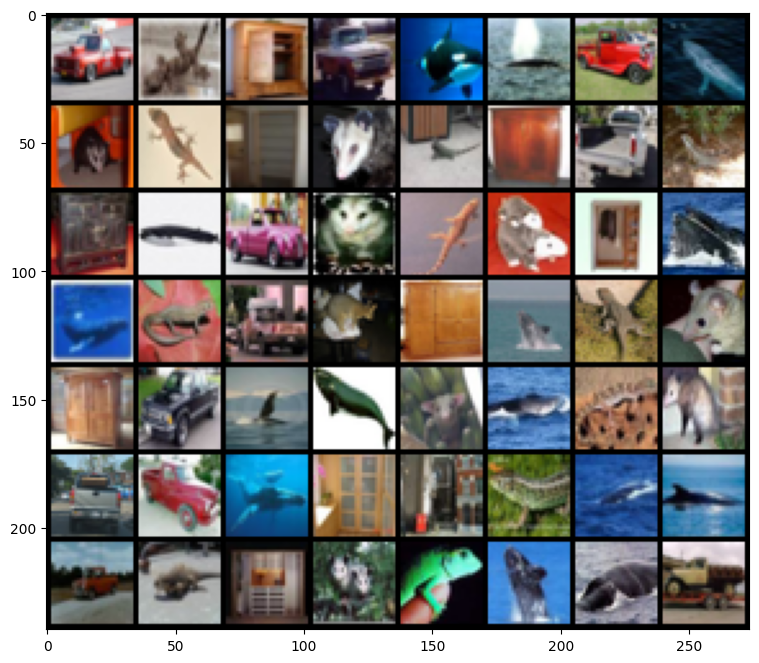

In [ ]:
Xt_haf_o = Xt_haf.cpu()
images = make_grid(Xt_haf_o)
plt.figure(figsize=(20, 8))
plt.imshow(np.transpose(images, (1, 2, 0)));

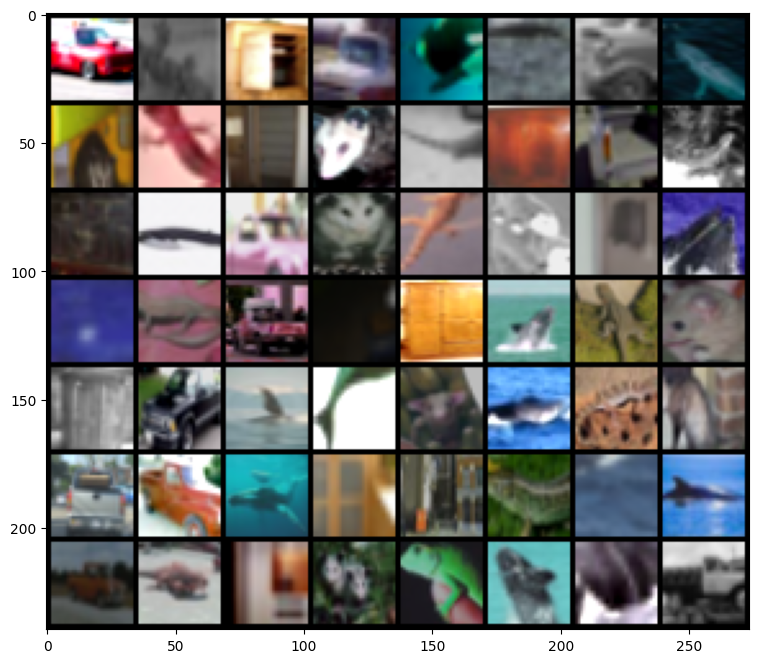

In [ ]:
Xt_other_o = Xt_other.cpu()
images = make_grid(Xt_other_o)
plt.figure(figsize=(20, 8))
plt.imshow(np.transpose(images, (1, 2, 0)));